# Materialized Views in Apache Iceberg

In [1]:
from pyspark.sql import SparkSession
import os

In [2]:
spark = (
    SparkSession.builder
    .appName("Materialized Views in Iceberg")
    .master("spark://spark:7077") 
    .getOrCreate()
)

In [6]:
spark.sql("""SELECT
    date_trunc('week', CAST(o.timestamp AS DATE)) AS week,
    o.customer_id,
    COUNT(DISTINCT o.id) AS total_orders,
    ROUND(SUM(oi.quantity * p.price), 2) AS total_revenue
FROM ice.demo.orders o
JOIN ice.demo.order_items oi ON o.id = oi.order_id
JOIN ice.demo.products p ON oi.product_id = p.product_id
GROUP BY date_trunc('week', CAST(o.timestamp AS DATE)), o.customer_id
ORDER BY week, o.customer_id""").show()

+-------------------+-----------+------------+-------------+
|               week|customer_id|total_orders|total_revenue|
+-------------------+-----------+------------+-------------+
|2025-09-29 00:00:00|          3|           1|       519.88|
|2025-09-29 00:00:00|          7|           1|       819.84|
|2025-09-29 00:00:00|          8|           1|       959.88|
|2025-09-29 00:00:00|         12|           1|      1399.88|
|2025-09-29 00:00:00|         15|           1|      1119.88|
|2025-09-29 00:00:00|         19|           1|       739.92|
|2025-10-06 00:00:00|          1|           1|      1679.84|
|2025-10-06 00:00:00|          2|           1|       399.88|
|2025-10-06 00:00:00|          4|           1|       599.92|
|2025-10-06 00:00:00|          5|           1|       719.88|
|2025-10-06 00:00:00|          9|           1|       879.88|
|2025-10-06 00:00:00|         16|           1|       339.92|
|2025-10-06 00:00:00|         17|           1|       919.88|
|2025-10-06 00:00:00|   

In [8]:
spark.sql("""
SELECT
    o.customer_id,
    ROUND(SUM(oi.quantity * p.price), 2) AS total_spent,
    COUNT(DISTINCT o.id) AS total_orders,
    CURRENT_TIMESTAMP() AS snapshot_time
FROM ice.demo.orders o
JOIN ice.demo.order_items oi ON o.id = oi.order_id
JOIN ice.demo.products p ON oi.product_id = p.product_id
GROUP BY o.customer_id
""").show()

+-----------+-----------+------------+--------------------+
|customer_id|total_spent|total_orders|       snapshot_time|
+-----------+-----------+------------+--------------------+
|         12|    1399.88|           1|2025-10-27 20:37:...|
|         22|     579.88|           1|2025-10-27 20:37:...|
|          1|    1679.84|           1|2025-10-27 20:37:...|
|         13|     799.84|           1|2025-10-27 20:37:...|
|         16|     339.92|           1|2025-10-27 20:37:...|
|          6|     839.88|           1|2025-10-27 20:37:...|
|          3|     519.88|           1|2025-10-27 20:37:...|
|          5|     719.88|           1|2025-10-27 20:37:...|
|         19|     739.92|           1|2025-10-27 20:37:...|
|         15|    1119.88|           1|2025-10-27 20:37:...|
|         17|     919.88|           1|2025-10-27 20:37:...|
|          9|     879.88|           1|2025-10-27 20:37:...|
|          4|     599.92|           1|2025-10-27 20:37:...|
|          8|     959.88|           1|20

In [9]:
spark.sql("""
CREATE OR REPLACE TABLE ice.demo.customer_spend_summary AS
SELECT
    o.customer_id,
    ROUND(SUM(oi.quantity * p.price), 2) AS total_spent,
    COUNT(DISTINCT o.id) AS total_orders,
    CURRENT_TIMESTAMP() AS snapshot_time
FROM ice.demo.orders o
JOIN ice.demo.order_items oi ON o.id = oi.order_id
JOIN ice.demo.products p ON oi.product_id = p.product_id
GROUP BY o.customer_id
""")

DataFrame[]

Let's query the new table made from the multiple joins

In [10]:
spark.sql("""
SELECT * from ice.demo.customer_spend_summary;
""").show()

+-----------+-----------+------------+--------------------+
|customer_id|total_spent|total_orders|       snapshot_time|
+-----------+-----------+------------+--------------------+
|         12|    1399.88|           1|2025-10-27 20:38:...|
|         22|     579.88|           1|2025-10-27 20:38:...|
|          1|    1679.84|           1|2025-10-27 20:38:...|
|         13|     799.84|           1|2025-10-27 20:38:...|
|         16|     339.92|           1|2025-10-27 20:38:...|
|          6|     839.88|           1|2025-10-27 20:38:...|
|          3|     519.88|           1|2025-10-27 20:38:...|
|          5|     719.88|           1|2025-10-27 20:38:...|
|         19|     739.92|           1|2025-10-27 20:38:...|
|         15|    1119.88|           1|2025-10-27 20:38:...|
|         17|     919.88|           1|2025-10-27 20:38:...|
|          9|     879.88|           1|2025-10-27 20:38:...|
|          4|     599.92|           1|2025-10-27 20:38:...|
|          8|     959.88|           1|20

#### Let's add 40 more sales!

In [11]:
spark.sql("""
INSERT INTO ice.demo.orders VALUES
('0c7adf4d-5a1f-493c-9f1a-1e1a6b4d4c01', TIMESTAMP '2025-10-18 10:12:05', 4),
('1a5b0b1a-6d23-4ce0-8b9f-2d0fd0fca202', TIMESTAMP '2025-10-18 11:44:37', 11),
('2e8c2e0f-3a9f-4d2a-9e7c-6a567a9f8c03', TIMESTAMP '2025-10-18 15:20:11', 19),
('3b7f3ad2-2d44-49e9-b4e4-9b0d5b6c7d04', TIMESTAMP '2025-10-18 18:59:52', 6),
('4d2a6c7b-9f1e-4d0a-8c2e-1a3b5d7f8e05', TIMESTAMP '2025-10-19 09:05:18', 15),
('5e3b7d9c-1f2a-42b0-9c8e-7d6a5b4c3a06', TIMESTAMP '2025-10-19 12:21:43', 8),
('6f4c8e0d-2a3b-41c0-8d9e-5c4b3a2f1e07', TIMESTAMP '2025-10-19 16:45:29', 21),
('7a5d9f1e-3b4c-42d1-9e0f-6d5c4b3a2e08', TIMESTAMP '2025-10-19 20:31:02', 2),
('8b6e0a2f-4c5d-43e2-8f10-7e6d5c4b3a09', TIMESTAMP '2025-10-20 08:14:56', 12),
('9c7f1b3e-5d6e-44f3-9a21-8f7e6d5c4b10', TIMESTAMP '2025-10-20 11:37:21', 5),
('a08e2c4d-6e7f-4504-8b32-9a8f7e6d5c11', TIMESTAMP '2025-10-20 14:58:47', 17),
('b19f3d5e-7f80-4615-9c43-0b9a8f7e6d12', TIMESTAMP '2025-10-20 18:20:33', 3),
('c2a04e6f-8091-4726-8d54-1c0b9a8f7e13', TIMESTAMP '2025-10-21 09:11:05', 22),
('d3b15f80-91a2-4837-9e65-2d1c0b9a8f14', TIMESTAMP '2025-10-21 10:49:42', 10),
('e4c27091-a2b3-4948-8f76-3e2d1c0b9a15', TIMESTAMP '2025-10-21 13:33:09', 7),
('f5d381a2-b3c4-4a59-9a87-4f3e2d1c0b16', TIMESTAMP '2025-10-21 17:05:55', 14),
('06e492b3-c4d5-4b6a-8b98-504f3e2d1c17', TIMESTAMP '2025-10-22 08:07:13', 1),
('17f5a3c4-d5e6-4c7b-9ca9-61504f3e2d18', TIMESTAMP '2025-10-22 10:12:49', 9),
('2816b4d5-e6f7-4d8c-8dba-7261504f3e19', TIMESTAMP '2025-10-22 12:58:31', 16),
('3927c5e6-f708-4e9d-9ecb-837261504f20', TIMESTAMP '2025-10-22 19:44:02', 13),
('4a38d6f7-0819-4fae-8fdc-948372615021', TIMESTAMP '2025-10-23 09:22:45', 18),
('5b49e708-192a-40bf-9aed-a58372615022', TIMESTAMP '2025-10-23 11:39:58', 20),
('6c5af819-2a3b-41c0-8bde-b69483726123', TIMESTAMP '2025-10-23 14:55:16', 11),
('7d6b091a-3b4c-42d1-9cef-c7a594837224', TIMESTAMP '2025-10-23 18:27:41', 4),
('8e7c1a2b-4c5d-43e2-8df0-d8b6a5948325', TIMESTAMP '2025-10-24 08:03:29', 6),
('9f8d2b3c-5d6e-44f3-9e01-e9c7b6a59426', TIMESTAMP '2025-10-24 11:21:56', 21),
('a09e3c4d-6e7f-4504-8f12-faD8c7b6a527', TIMESTAMP '2025-10-24 13:14:07', 8),
('b1af4d5e-7f80-4615-9a23-0be9d8c7b628', TIMESTAMP '2025-10-24 16:52:44', 2),
('c2b05e6f-8091-4726-8b34-1c0ed9d8c729', TIMESTAMP '2025-10-24 20:05:18', 5),
('d3c16f80-91a2-4837-9c45-2d1f0ed9d730', TIMESTAMP '2025-10-25 09:11:55', 12),
('e4d27091-a2b3-4948-8d56-3e201f0ed731', TIMESTAMP '2025-10-25 12:40:36', 7),
('f5e381a2-b3c4-4a59-9e67-4f32201f0e32', TIMESTAMP '2025-10-25 15:19:22', 19),
('06f492b3-c4d5-4b6a-8f78-503433201f33', TIMESTAMP '2025-10-25 18:48:10', 9),
('1705a3c4-d5e6-4c7b-9a89-614034332034', TIMESTAMP '2025-10-26 08:09:44', 3),
('2816b4d5-e6f7-4d8c-8b9a-726140343235', TIMESTAMP '2025-10-26 10:22:19', 10),
('3927c5e6-f708-4e9d-9c0b-837261403436', TIMESTAMP '2025-10-26 13:05:50', 14),
('4a38d6f7-0819-4fae-8d1c-948372614037', TIMESTAMP '2025-10-26 16:47:03', 1),
('5b49e708-192a-40bf-9e2d-a58372614038', TIMESTAMP '2025-10-26 19:58:27', 16),
('6c5af819-2a3b-41c0-8f3e-b69483726139', TIMESTAMP '2025-10-27 08:12:33', 18),
('7d6b091a-3b4c-42d1-9a4f-c7a594837240', TIMESTAMP '2025-10-27 10:55:41', 13)
""")

DataFrame[]

In [12]:
spark.sql("""
INSERT INTO ice.demo.order_items VALUES
('11111111-1111-4111-8111-111111111101','0c7adf4d-5a1f-493c-9f1a-1e1a6b4d4c01', 13, 1),
('22222222-2222-4222-8222-222222222202','0c7adf4d-5a1f-493c-9f1a-1e1a6b4d4c01', 21, 2),

('33333333-3333-4333-8333-333333333303','1a5b0b1a-6d23-4ce0-8b9f-2d0fd0fca202', 8, 1),
('44444444-4444-4444-8444-444444444404','1a5b0b1a-6d23-4ce0-8b9f-2d0fd0fca202', 3, 2),

('55555555-5555-4555-8555-555555555505','2e8c2e0f-3a9f-4d2a-9e7c-6a567a9f8c03', 18, 1),

('66666666-6666-4666-8666-666666666606','3b7f3ad2-2d44-49e9-b4e4-9b0d5b6c7d04', 6, 1),
('77777777-7777-4777-8777-777777777707','3b7f3ad2-2d44-49e9-b4e4-9b0d5b6c7d04', 15, 1),

('88888888-8888-4888-8888-888888888808','4d2a6c7b-9f1e-4d0a-8c2e-1a3b5d7f8e05', 20, 1),

('99999999-9999-4999-8999-999999999909','5e3b7d9c-1f2a-42b0-9c8e-7d6a5b4c3a06', 5, 1),
('aaaaaaa0-aaaa-4aaa-8aaa-aaaaaaaaaaa0','5e3b7d9c-1f2a-42b0-9c8e-7d6a5b4c3a06', 10, 1),

('bbbbbbb1-bbbb-4bbb-8bbb-bbbbbbbbbbb1','6f4c8e0d-2a3b-41c0-8d9e-5c4b3a2f1e07', 24, 1),

('ccccccc2-cccc-4ccc-8ccc-ccccccccccc2','7a5d9f1e-3b4c-42d1-9e0f-6d5c4b3a2e08', 1, 2),

('ddddddd3-dddd-4ddd-8ddd-ddddddddddd3','8b6e0a2f-4c5d-43e2-8f10-7e6d5c4b3a09', 9, 1),
('eeeeeee4-eeee-4eee-8eee-eeeeeeeeeee4','8b6e0a2f-4c5d-43e2-8f10-7e6d5c4b3a09', 11, 1),

('fffffff5-ffff-4fff-8fff-fffffffffff5','9c7f1b3e-5d6e-44f3-9a21-8f7e6d5c4b10', 14, 1),

('00000006-0000-4000-8000-000000000006','a08e2c4d-6e7f-4504-8b32-9a8f7e6d5c11', 7, 2),

('12345678-0000-4000-8000-000000000007','b19f3d5e-7f80-4615-9c43-0b9a8f7e6d12', 16, 1),
('22345678-0000-4000-8000-000000000008','b19f3d5e-7f80-4615-9c43-0b9a8f7e6d12', 2, 1),

('32345678-0000-4000-8000-000000000009','c2a04e6f-8091-4726-8d54-1c0b9a8f7e13', 23, 1),

('42345678-0000-4000-8000-000000000010','d3b15f80-91a2-4837-9e65-2d1c0b9a8f14', 6, 1),

('52345678-0000-4000-8000-000000000011','e4c27091-a2b3-4948-8f76-3e2d1c0b9a15', 12, 2),

('62345678-0000-4000-8000-000000000012','f5d381a2-b3c4-4a59-9a87-4f3e2d1c0b16', 3, 1),
('72345678-0000-4000-8000-000000000013','f5d381a2-b3c4-4a59-9a87-4f3e2d1c0b16', 4, 1),

('82345678-0000-4000-8000-000000000014','06e492b3-c4d5-4b6a-8b98-504f3e2d1c17', 5, 1),

('92345678-0000-4000-8000-000000000015','17f5a3c4-d5e6-4c7b-9ca9-61504f3e2d18', 18, 1),

('a2345678-0000-4000-8000-000000000016','2816b4d5-e6f7-4d8c-8dba-7261504f3e19', 8, 1),
('b2345678-0000-4000-8000-000000000017','2816b4d5-e6f7-4d8c-8dba-7261504f3e19', 19, 1),

('c2345678-0000-4000-8000-000000000018','3927c5e6-f708-4e9d-9ecb-837261504f20', 10, 1),

('d2345678-0000-4000-8000-000000000019','4a38d6f7-0819-4fae-8fdc-948372615021', 25, 1),
('e2345678-0000-4000-8000-000000000020','4a38d6f7-0819-4fae-8fdc-948372615021', 14, 1),

('f2345678-0000-4000-8000-000000000021','5b49e708-192a-40bf-9aed-a58372615022', 9, 2),

('01234567-89ab-41cd-8ef0-0123456789a1','6c5af819-2a3b-41c0-8bde-b69483726123', 22, 1),

('11234567-89ab-41cd-8ef0-1123456789a2','7d6b091a-3b4c-42d1-9cef-c7a594837224', 7, 1),
('21234567-89ab-41cd-8ef0-2123456789a3','7d6b091a-3b4c-42d1-9cef-c7a594837224', 1, 1),

('31234567-89ab-41cd-8ef0-3123456789a4','8e7c1a2b-4c5d-43e2-8df0-d8b6a5948325', 4, 1),

('41234567-89ab-41cd-8ef0-4123456789a5','9f8d2b3c-5d6e-44f3-9e01-e9c7b6a59426', 11, 1),

('51234567-89ab-41cd-8ef0-5123456789a6','a09e3c4d-6e7f-4504-8f12-faD8c7b6a527', 13, 1),

('61234567-89ab-41cd-8ef0-6123456789a7','b1af4d5e-7f80-4615-9a23-0be9d8c7b628', 5, 1),
('71234567-89ab-41cd-8ef0-7123456789a8','b1af4d5e-7f80-4615-9a23-0be9d8c7b628', 2, 2),

('81234567-89ab-41cd-8ef0-8123456789a9','c2b05e6f-8091-4726-8b34-1c0ed9d8c729', 6, 1),

('91234567-89ab-41cd-8ef0-9123456789b0','d3c16f80-91a2-4837-9c45-2d1f0ed9d730', 20, 1),

('a1234567-89ab-41cd-8ef0-a123456789b1','e4d27091-a2b3-4948-8d56-3e201f0ed731', 24, 1),

('b1234567-89ab-41cd-8ef0-b123456789b2','f5e381a2-b3c4-4a59-9e67-4f32201f0e32', 15, 1),

('c1234567-89ab-41cd-8ef0-c123456789b3','06f492b3-c4d5-4b6a-8f78-503433201f33', 10, 1),
('d1234567-89ab-41cd-8ef0-d123456789b4','06f492b3-c4d5-4b6a-8f78-503433201f33', 3, 1),

('e1234567-89ab-41cd-8ef0-e123456789b5','1705a3c4-d5e6-4c7b-9a89-614034332034', 18, 2),

('f1234567-89ab-41cd-8ef0-f123456789b6','2816b4d5-e6f7-4d8c-8b9a-726140343235', 9, 1),

('0abc4567-89ab-41cd-8ef0-0abc456789b7','3927c5e6-f708-4e9d-9c0b-837261403436', 21, 1),
('1abc4567-89ab-41cd-8ef0-1abc456789b8','3927c5e6-f708-4e9d-9c0b-837261403436', 4, 1),

('2abc4567-89ab-41cd-8ef0-2abc456789b9','4a38d6f7-0819-4fae-8d1c-948372614037', 16, 1),

('3abc4567-89ab-41cd-8ef0-3abc456789c0','5b49e708-192a-40bf-9e2d-a58372614038', 12, 1),
('4abc4567-89ab-41cd-8ef0-4abc456789c1','5b49e708-192a-40bf-9e2d-a58372614038', 19, 1),

('5abc4567-89ab-41cd-8ef0-5abc456789c2','6c5af819-2a3b-41c0-8f3e-b69483726139', 7, 1),

('6abc4567-89ab-41cd-8ef0-6abc456789c3','7d6b091a-3b4c-42d1-9a4f-c7a594837240', 1, 1),
('7abc4567-89ab-41cd-8ef0-7abc456789c4','7d6b091a-3b4c-42d1-9a4f-c7a594837240', 22, 1)
""")

DataFrame[]

Then let's query it again

In [13]:
spark.sql("""
SELECT * from ice.demo.customer_spend_summary;
""").show()

+-----------+-----------+------------+--------------------+
|customer_id|total_spent|total_orders|       snapshot_time|
+-----------+-----------+------------+--------------------+
|         12|    1399.88|           1|2025-10-27 20:38:...|
|         22|     579.88|           1|2025-10-27 20:38:...|
|          1|    1679.84|           1|2025-10-27 20:38:...|
|         13|     799.84|           1|2025-10-27 20:38:...|
|         16|     339.92|           1|2025-10-27 20:38:...|
|          6|     839.88|           1|2025-10-27 20:38:...|
|          3|     519.88|           1|2025-10-27 20:38:...|
|          5|     719.88|           1|2025-10-27 20:38:...|
|         19|     739.92|           1|2025-10-27 20:38:...|
|         15|    1119.88|           1|2025-10-27 20:38:...|
|         17|     919.88|           1|2025-10-27 20:38:...|
|          9|     879.88|           1|2025-10-27 20:38:...|
|          4|     599.92|           1|2025-10-27 20:38:...|
|          8|     959.88|           1|20

Let's regenerate the view, since it is merely a snapshot of the last creation

In [14]:
spark.sql("""
INSERT OVERWRITE ice.demo.customer_spend_summary
SELECT
    o.customer_id,
    ROUND(SUM(oi.quantity * p.price), 2) AS total_spent,
    COUNT(DISTINCT o.id) AS total_orders,
    CURRENT_TIMESTAMP() AS snapshot_time
FROM ice.demo.orders o
JOIN ice.demo.order_items oi ON o.id = oi.order_id
JOIN ice.demo.products p ON oi.product_id = p.product_id
GROUP BY o.customer_id
""")

DataFrame[]

In [15]:
spark.sql("""
SELECT * from ice.demo.customer_spend_summary;
""").show()

+-----------+-----------+------------+--------------------+
|customer_id|total_spent|total_orders|       snapshot_time|
+-----------+-----------+------------+--------------------+
|         12|    1559.85|           3|2025-10-27 20:50:...|
|         22|     729.87|           2|2025-10-27 20:50:...|
|          1|    1859.82|           3|2025-10-27 20:50:...|
|         13|     914.81|           3|2025-10-27 20:50:...|
|         16|     564.88|           3|2025-10-27 20:50:...|
|          6|    1309.85|           3|2025-10-27 20:50:...|
|          3|     909.84|           3|2025-10-27 20:50:...|
|         20|      39.98|           1|2025-10-27 20:50:...|
|          5|    1269.86|           3|2025-10-27 20:50:...|
|         19|      869.9|           3|2025-10-27 20:50:...|
|         15|    1199.87|           2|2025-10-27 20:50:...|
|         17|     989.86|           2|2025-10-27 20:50:...|
|          9|    1039.85|           3|2025-10-27 20:50:...|
|          4|    1159.87|           3|20

Add more sales for diverse patterns

In [16]:
spark.sql("""
INSERT INTO ice.demo.orders VALUES
  ('b6c8d3b7-1a2f-4b88-94ab-0d7a91a5b201', TIMESTAMP '2025-10-28 09:35:10', 3),
  ('c7d9e4c8-2b3f-4c99-a5bc-1e8b02b6c302', TIMESTAMP '2025-10-28 13:22:44', 9),
  ('d8e0f5d9-3c4f-4daa-b6cd-2f9c13c7d403', TIMESTAMP '2025-10-28 18:47:59', 15)
""")

spark.sql("""
INSERT INTO ice.demo.order_items VALUES
  ('111aaa11-aaaa-4111-8aaa-111111aaa001','b6c8d3b7-1a2f-4b88-94ab-0d7a91a5b201', 5, 2),
  ('222bbb22-bbbb-4222-8bbb-222222bbb002','b6c8d3b7-1a2f-4b88-94ab-0d7a91a5b201', 13, 1),
  ('333ccc33-cccc-4333-8ccc-333333ccc003','b6c8d3b7-1a2f-4b88-94ab-0d7a91a5b201', 20, 1),

  ('444ddd44-dddd-4444-8ddd-444444ddd004','c7d9e4c8-2b3f-4c99-a5bc-1e8b02b6c302', 7, 1),
  ('555eee55-eeee-4555-8eee-555555eee005','c7d9e4c8-2b3f-4c99-a5bc-1e8b02b6c302', 9, 2),

  ('666fff66-ffff-4666-8fff-666666fff006','d8e0f5d9-3c4f-4daa-b6cd-2f9c13c7d403', 16, 1),
  ('777ggg77-gggg-4777-8ggg-777777ggg007','d8e0f5d9-3c4f-4daa-b6cd-2f9c13c7d403', 2, 2)
""")

DataFrame[]

Then query it again

In [17]:
spark.sql("""
INSERT OVERWRITE ice.demo.customer_spend_summary
SELECT
    o.customer_id,
    ROUND(SUM(oi.quantity * p.price), 2) AS total_spent,
    COUNT(DISTINCT o.id) AS total_orders,
    CURRENT_TIMESTAMP() AS snapshot_time
FROM ice.demo.orders o
JOIN ice.demo.order_items oi ON o.id = oi.order_id
JOIN ice.demo.products p ON oi.product_id = p.product_id
GROUP BY o.customer_id
""")

DataFrame[]

Show the results

In [18]:
spark.sql("""
SELECT * from ice.demo.customer_spend_summary;
""").show()

+-----------+-----------+------------+--------------------+
|customer_id|total_spent|total_orders|       snapshot_time|
+-----------+-----------+------------+--------------------+
|         12|    1559.85|           3|2025-10-27 20:52:...|
|         22|     729.87|           2|2025-10-27 20:52:...|
|          1|    1859.82|           3|2025-10-27 20:52:...|
|         13|     914.81|           3|2025-10-27 20:52:...|
|         16|     564.88|           3|2025-10-27 20:52:...|
|          6|    1309.85|           3|2025-10-27 20:52:...|
|          3|     1489.8|           4|2025-10-27 20:52:...|
|         20|      39.98|           1|2025-10-27 20:52:...|
|          5|    1269.86|           3|2025-10-27 20:52:...|
|         19|      869.9|           3|2025-10-27 20:52:...|
|         15|    1489.84|           3|2025-10-27 20:52:...|
|         17|     989.86|           2|2025-10-27 20:52:...|
|          9|    1114.82|           4|2025-10-27 20:52:...|
|          4|    1159.87|           3|20

Let's add a visualization component to our aggregate

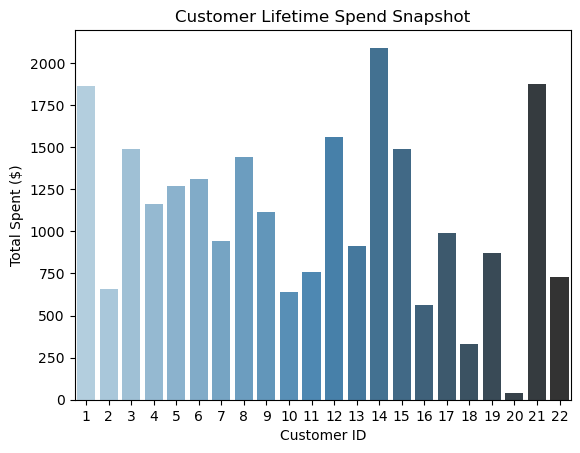

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = spark.sql("SELECT * FROM ice.demo.customer_spend_summary").toPandas()
sns.barplot(
    data=df,
    x="customer_id",
    y="total_spent",
    hue="customer_id",  
    palette="Blues_d",
    legend=False
)
plt.title("Customer Lifetime Spend Snapshot")
plt.xlabel("Customer ID")
plt.ylabel("Total Spent ($)")
plt.show()

In [22]:
spark.stop()